### Truncated Incremental k-DPP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal
from scipy.interpolate import fitpack,bisplrep,bisplev
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
print ("Packages loaded.")

Packages loaded.


### Implementations

In [2]:
def grid_2d(x0_min,x0_max,x1_min,x1_max,x0_step,x1_step):
    x0s,x1s = np.meshgrid(np.arange(x0_min,x0_max+x0_step,x0_step),
                          np.arange(x1_min,x1_max+x1_step,x1_step))
    xs = np.dstack([x0s,x1s]).reshape(-1,2) 
    return xs,x0s,x1s

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    from mpl_toolkits import axes_grid1
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

def gmm(x,weights,mus,sigmas):
    n = x.shape[0]
    prob = np.zeros(shape=(n,1))
    for i_idx,x_i in enumerate(x):
        p_i = 0
        for weight,mu,sigma in zip(weights,mus,sigmas):
            weight = weight / np.array(weights).sum()
            p_i = p_i + weight*multivariate_normal.pdf(x_i,mean=mu,cov=sigma)
        prob[i_idx,0] = p_i
    return prob

class QualityMapClass(object):
    def __init__(self,
                 name        = 'QM',
                 axis_info   = [-1.5,1.5,-1,1],
                 step_coarse = 0.05,
                 step_fine   = 0.01,
                 gmm_weights = [1,2,3],
                 gmm_mus     = [
                     np.array([-1.0,-0.5]),
                     np.array([0.0,0.0]),
                     np.array([1.0,0.5])
                     ],
                 gmm_sigmas  = [
                     0.1*np.array([[1.0,0.0],[0.0,1.0]]),
                     0.1*np.array([[1.0,0.0],[0.0,1.0]]),
                     0.1*np.array([[1.0,0.0],[0.0,1.0]])
                     ]
                ):
        self.name        = name
        self.axis_info   = axis_info
        self.step_coarse = step_coarse
        self.step_fine   = step_fine
        self.gmm_weights = gmm_weights
        self.gmm_mus     = gmm_mus
        self.gmm_sigmas  = gmm_sigmas
        
        # Define a GMM for the quality map
        xs,x0s,x1s = grid_2d(x0_min  = self.axis_info[0],
                             x0_max  = self.axis_info[1],
                             x1_min  = self.axis_info[2],
                             x1_max  = self.axis_info[3],
                             x0_step = self.step_coarse,
                             x1_step = self.step_coarse)
        self.xs_coarse  = xs
        self.x0s_coarse = x0s
        self.x1s_coarse = x1s
        self.prob = gmm(
            x       = self.xs_coarse,
            weights = self.gmm_weights,
            mus     = self.gmm_mus,
            sigmas  = self.gmm_sigmas)
        self.tck_coarse = bisplrep(
            x  = self.xs_coarse[:,0],
            y  = self.xs_coarse[:,1],
            z  = self.prob/max(self.prob),
            s  = 0.001,
            kx = 3,
            ky = 3)
        # 2D interpolating function and the qaulity map
        xs,x0s,x1s = grid_2d(x0_min  = self.axis_info[0],
                             x0_max  = self.axis_info[1],
                             x1_min  = self.axis_info[2],
                             x1_max  = self.axis_info[3],
                             x0_step = self.step_fine,
                             x1_step = self.step_fine)
        self.xs_fine  = xs
        self.x0s_fine = x0s
        self.x1s_fine = x1s
        self.Q    = bisplev(
            np.arange(self.axis_info[0],self.axis_info[1]+self.step_fine,self.step_fine),
            np.arange(self.axis_info[2],self.axis_info[3]+self.step_fine,self.step_fine),
            self.tck_coarse).T
    
    def get_meas(self,n_meas=100):
        """
            Make measurements
        """
        x_meas = np.array([self.axis_info[0],self.axis_info[2]]) \
            + np.array([self.axis_info[1]-self.axis_info[0],
                        self.axis_info[3]-self.axis_info[2]])*np.random.rand(n_meas,2)
        y_meas = np.zeros(shape=(n_meas))
        for i_idx in range(n_meas):
            y_meas[i_idx] = bisplev(
                x=x_meas[i_idx,0],y=x_meas[i_idx,1],tck=self.tck_coarse)
        return x_meas,y_meas
    
def kernel_se(X1,X2,hyp={'g':1.0,'l':1.0}):
    """
        Squared exponential (SE) kernel function
    """
    K = hyp['g']*np.exp(-cdist(X1,X2,'sqeuclidean')/(2*hyp['l']*hyp['l']))
    return K

def block_mtx(M11,M12,M21,M22):
    M_upper = np.concatenate((M11,M12),axis=1)
    M_lower = np.concatenate((M21,M22),axis=1)
    M = np.concatenate((M_upper,M_lower),axis=0)
    return M

def inv_inc(inv_A,b,c):
    """
        Incremental inverse using matrix inverse lemma
    """
    k   = c - b.T @ inv_A @ b
    M11 = inv_A + 1/k * inv_A @ b @ b.T @ inv_A
    M12 = -1/k * inv_A @ b
    M21 = -1/k * b.T @ inv_A
    M22 = 1/k
    M   = block_mtx(M11=M11,M12=M12,M21=M21,M22=M22)
    return M

def det_inc(det_A,inv_A,b,c):
    """
        Incremental determinant computation
    """
    out = det_A * (c - b.T @ inv_A @ b)
    return out

def kdpp(
    xs_total,
    qs_total = None,
    n_select = 10,
    hyp      = {'g':1.0,'l':1.0}
    ):
    """
        Original k-DPP
    """
    n_total     = xs_total.shape[0]
    idxs_remain = np.arange(0,n_total,1,dtype=np.int32)
    idxs_select = []
    for i_idx in range(n_select+1): # loop
        n_remain = len(idxs_remain)
        if i_idx == 0: # random first
            idx_select = np.random.permutation(n_total)[0]
        else:
            xs_select = xs_total[idxs_select,:]
            # Compute determinants
            dets = np.zeros(shape=n_remain)
            for r_idx in range(n_remain): # for the remained indices
                idx_check  = idxs_remain[r_idx]
                idxs_check = idxs_select + [idx_check]
                xs_check   = xs_total[idxs_check,:]
                # Compute the determinant of the kernel matrix 
                K_check    = kernel_se(xs_check,xs_check,hyp=hyp)
                if qs_total is not None:
                    K_check = K_check + np.diag(qs_total[idxs_check])
                det_check  = np.linalg.det(K_check)
                # Append the determinant
                dets[r_idx] = det_check
            # Get the index with the highest determinant
            idx_select = idxs_remain[np.where(dets == np.amax(dets))[0][0]]
        # Remove currently selected index from 'idxs_remain'
        idxs_remain = idxs_remain[idxs_remain != idx_select]
        # Append currently selected index to 'idxs_select'
        idxs_select.append(idx_select)
    # Select the subset from 'xs_total' with removing the first sample
    idxs_select = idxs_select[1:] # excluding the first one
    idxs_kdpp   = np.array(idxs_select)
    xs_kdpp     = xs_total[idxs_kdpp]
    return xs_kdpp,idxs_kdpp

def ikdpp(
    xs_total,
    qs_total = None,
    n_select = 10,
    n_trunc  = np.inf,
    hyp      = {'g':1.0,'l':1.0}
    ):
    """
        (Truncated) Incremental k-DPP
    """
    n_total     = xs_total.shape[0]
    idxs_remain = np.arange(0,n_total,1,dtype=np.int32)
    idxs_select = []
    for i_idx in range(n_select+1): # loop
        n_remain = len(idxs_remain)
        if i_idx == 0: # random first
            idx_select = np.random.permutation(n_total)[0]
            if qs_total is not None:
                q = 1.0+qs_total[idx_select]
            else:
                q = 1.0
            det_K_prev = q
            K_inv_prev = 1/q*np.ones(shape=(1,1))
        else:
            xs_select = xs_total[idxs_select,:]
            # Compute determinants
            dets = np.zeros(shape=n_remain)
            # for r_idx in range(n_remain): # for the remained indices
            for r_idx in np.random.permutation(n_remain)[:min(n_remain,n_trunc)]:
                # Compute the determinant of the appended kernel matrix 
                k_vec     = kernel_se(
                    X1  = xs_select,
                    X2  = xs_total[idxs_remain[r_idx],:].reshape(1,-1),
                    hyp = hyp)
                if qs_total is not None:
                    q = qs_total[idxs_remain[r_idx]]
                else:
                    q = 1.0
                det_check = det_inc(
                    det_A = det_K_prev,
                    inv_A = K_inv_prev,
                    b     = k_vec,
                    c     = q)
                # Append the determinant
                dets[r_idx] = det_check
            # Get the index with the highest determinant
            idx_temp   = np.where(dets == np.amax(dets))[0][0]
            idx_select = idxs_remain[idx_temp]
            
            # Compute 'det_K_prev' and 'K_inv_prev'
            det_K_prev = dets[idx_temp]
            k_vec      = kernel_se(
                xs_select,
                xs_total[idx_select,:].reshape(1,-1),
                hyp=hyp)
            q          = 1+qs_total[idx_select]
            K_inv_prev = inv_inc(
                inv_A = K_inv_prev,
                b     = k_vec,
                c     = q)
        # Remove currently selected index from 'idxs_remain'
        idxs_remain = idxs_remain[idxs_remain != idx_select]
        # Append currently selected index to 'idxs_select'
        idxs_select.append(idx_select)
    # Select the subset from 'xs_total' with removing the first sample
    idxs_select = idxs_select[1:] # excluding the first one
    idxs_ikdpp  = np.array(idxs_select)
    xs_ikdpp    = xs_total[idxs_ikdpp]
    return xs_ikdpp,idxs_ikdpp

print ("Done.")

Done.


### Run DPP

In [3]:
np.random.seed(seed=0)
n_total           = 2000
n_select          = 100
hyp               = {'g':1.0,'l':0.1}
QM                = QualityMapClass()
xs_total,qs_total = QM.get_meas(n_meas=n_total)
print ("n_total:[%d] n_select:[%d] "%(n_total,n_select))

n_total:[2000] n_select:[100] 


In [4]:
# Original k-DPP
np.random.seed(seed=0)
tic = datetime.now()
xs_kdpp,idxs_kdpp = kdpp(
    xs_total = xs_total,
    qs_total = qs_total,
    n_select = n_select,
    hyp      = hyp)
toc = (datetime.now()-tic).total_seconds()
print ("Original k-DPP took [%.3f] second"%(toc))

Original k-DPP took [10.464] second


In [5]:
# Incremental k-DPP
np.random.seed(seed=0)
tic = datetime.now()
xs_ikdpp,idxs_ikdpp = ikdpp(
    xs_total = xs_total,
    qs_total = qs_total,
    n_select = n_select,
    hyp      = hyp)
toc = (datetime.now()-tic).total_seconds()
print ("Incremental k-DPP took [%.3f] second"%(toc))

Incremental k-DPP took [2.001] second


In [9]:
# Truncated Incremental k-DPP
np.random.seed(seed=0)
tic = datetime.now()
xs_tikdpp,idxs_tikdpp = ikdpp(
    xs_total = xs_total,
    qs_total = qs_total,
    n_select = n_select,
    n_trunc  = 20,
    hyp      = hyp)
toc = (datetime.now()-tic).total_seconds()
print ("Truncated Incremental k-DPP took [%.3f] second"%(toc))

Truncated Incremental k-DPP took [0.062] second


### Plot

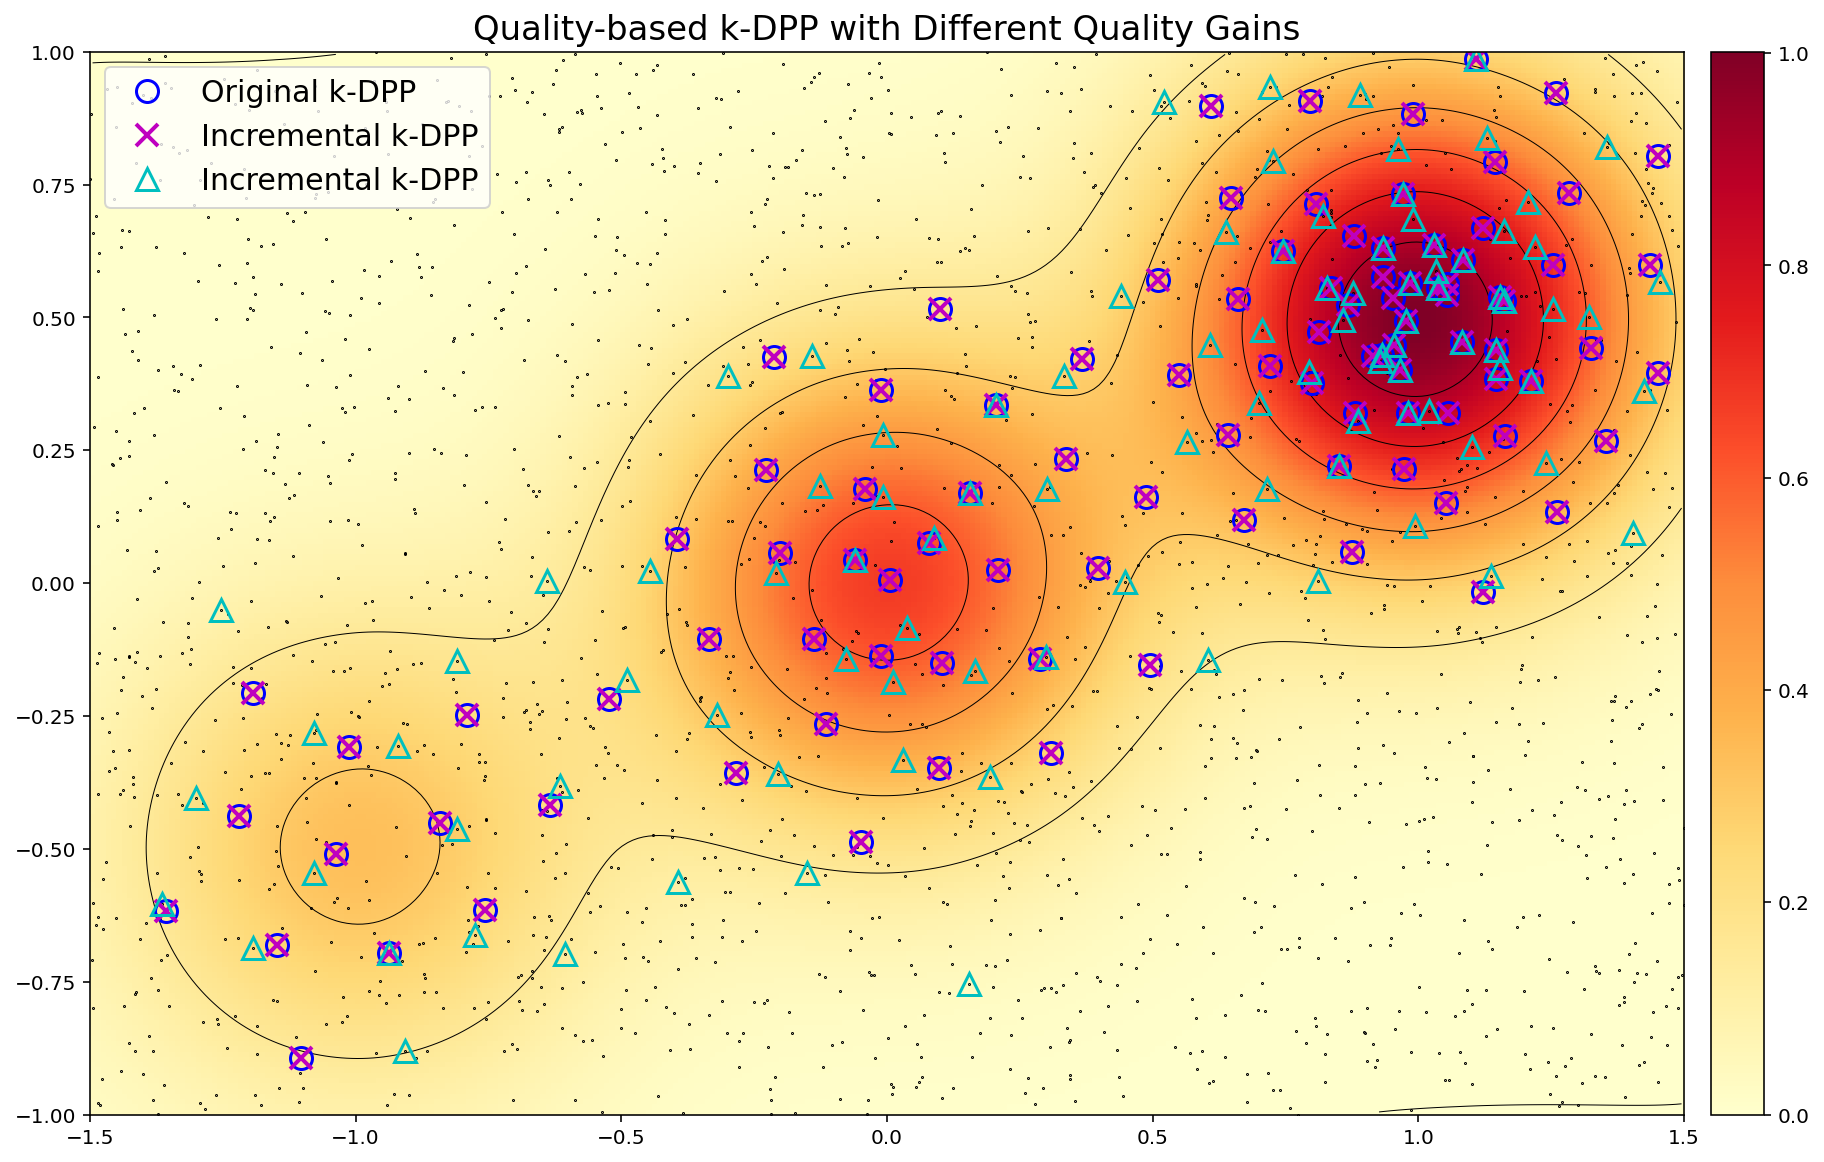

In [12]:
plt.figure(figsize = (15,10))
plt.rcParams.update({'font.size':10})
im = plt.imshow(X      = QM.Q,
                extent = QM.axis_info,
                cmap   = 'YlOrRd',
                origin = 'lower')
plt.contour(QM.Q,
            extent     = QM.axis_info,
            origin     = 'lower',
            colors     = 'k',
            linewidths = 1/2)
plt.plot(xs_total[:,0],xs_total[:,1],'.',mfc='none',mec='k',ms=1,lw=1/2)
plt.plot(xs_kdpp[:,0],xs_kdpp[:,1],'o',ms=11,mfc='None',mec='b',
         markeredgewidth=1.5,label='Original k-DPP')
plt.plot(xs_ikdpp[:,0],xs_ikdpp[:,1],'x',ms=11,mfc='None',mec='m',
         markeredgewidth=2.0,label='Incremental k-DPP')
plt.plot(xs_tikdpp[:,0],xs_tikdpp[:,1],'^',ms=11,mfc='None',mec='c',
         markeredgewidth=1.5,label='Incremental k-DPP')
plt.title("Quality-based k-DPP with Different Quality Gains",fontsize=17)
plt.legend(fontsize=15,loc='upper left')
add_colorbar(im); plt.axis(QM.axis_info); plt.axis('equal'); 
plt.show()